convert to presentation: jupyter nbconvert Presentation.ipynb --to slides --no-prompt
jupyter nbconvert Presentation.ipynb --to slides --post serve

*Andrea Donazzan, Amadeus Lars Linge*
# Empirical Comparison of Option Pricing Models
Compare various techniques of option pricing estimation by using real market data

## Content
- Data collection
- Monte Carlo pricing models
- Calibration
- Pricing with Machine Learning
- Results

## Data Collection
**Goal:** build database with market price of options and information about underlying

Stock data: yfinance\
Option data: yahooquery

In [ ]:
from yahooquery import Ticker
Ticker('AAPL').option_chain

<center><img src="./Presentation%20files/Option_Chain.png"/></center>

## Modifying Option Chain
Add price of underlying, historical variablility, option maturity

In [ ]:
import Data
Data.GetData('2018,11,22', '2022,11,22', 252, False)

<center><img src="./Presentation%20files/Data_df.png"/></center>

# Pricing Models
European Options: 
- **Black Scholes** Model (GMB) 
- Merton's **Jump Diffusion** (GMB with Poisson)

American Options: 
- **Cox-Ross-Rubinstein** Model (Binomial Tree)
- **Longstaff-Schwartz** Model (Least Squares Monte Carlo)

## Black Scholes
$$
S(t_{i+1})=S(t_i)\exp\left(\left(\mu - \frac{\sigma}{2}\right)\Delta t + \sigma \sqrt{\Delta t} Z_{i+1}\right)
$$
## Jump Diffusion
$$
S(t_{i+1})=S(t_i)\exp\left(\left(\mu - \frac{\sigma}{2}\right)\Delta t + \sigma \sqrt{\Delta t} Z_{i+1} + aN_{i+1}+b\sqrt{N_{i+1}}Z_{i+1}' \right)\\
\quad
\\
\text{with } N_i \sim \text{Pois}(\lambda \Delta t)
$$

## American Options
Allow for **early exercise**: 

The value at each time step is the maximum between the payoff of exercising the option at that time step (early exercise value) and the expected value of holding the option to maturity (continuation value).

For an **American call** option:
$$
O_t^i = \max\left((S_t^i - K)^+,\: e^{-(T-t)r}(E[S_T|S_t^i] - K)^+ \right)
$$

## Binomial Trees 1: Simulate Stock Value
Stock price can:
- Move up to $uS_{0}$ with probability $q$
- Move down to $uS_{0}$ with probability $(1-q)$
$$
u = e^{\sigma \sqrt{\Delta t}}
\qquad
d = e^{-\sigma \sqrt{\Delta t}} = \frac{1}{u}
\qquad
q = \frac{e^{r\Delta t}-d}{u-d}\\
$$
Fill the best outcome nodes of the tree with $S_{i,0} = u S_{i-1,0}$ and the others with $S_{i,j}=d S_{i-1,j-1}$

<center><img src="./Presentation%20files/Stock_tree.png" width="400"/></center>

In [41]:
import numpy as np
import pandas as pd
N = 4
S0 = 1
dt = 1
sigma = 0.2
u = np.exp(sigma*np.sqrt(dt))
d = 1/u
K = 1.1
r = 0.1
q = (np.exp(r*dt) - d) / (u - d)
stock_tree = np.zeros((N+1, N+1))
stock_tree[0, 0] = S0

for i in range(1, N+1):
    stock_tree[i, 0] = stock_tree[i-1, 0] * u
    for j in range(1, i+1):
        stock_tree[i, j] = stock_tree[i-1, j-1] * d

pd.DataFrame(stock_tree)
# ![Binomial tree](./Presentation%20files/Binomial_tree.png)

,0,1,2,3,4
0,1.000000,0.000000,0.000000,0.000000,0.000000
1,1.221403,0.818731,0.000000,0.000000,0.000000
2,1.491825,1.000000,0.670320,0.000000,0.000000
3,1.822119,1.221403,0.818731,0.548812,0.000000
4,2.225541,1.491825,1.000000,0.670320,0.449329


## Binomial Trees 2: Compute Option Price
Start from end of tree and move upwards:

At maturity, compute value as $\max(S_{T,j}-K, 0) $

For each previous node compute 
$$
\quad O_{i,j} = \max \left(\underbrace{e^{-r\Delta t}(qO_{(i+1),j}+(1-q)O_{(i+1),(j+1)})}_\text{continuation value},\; \underbrace{S_{i,j}-K}_\text{immediate exercise}\right)
$$

<center><img src="./Presentation%20files/Option_tree.png" width="250"/></center>

In [42]:
option_tree = np.zeros((N+1, N+1))
for j in range(N+1):
    option_tree[N, j] = max(stock_tree[N, j] - K, 0)

for i in range(N-1, -1, -1):
    for j in range(i+1):
        option_tree[i, j] = max(np.exp(-r*dt) * (q * option_tree[i+1, j] + (1-q) * option_tree[i+1, j+1]), stock_tree[i, j] - K)

pd.DataFrame(option_tree).round(decimals = 2)


,0,1,2,3,4
0,0.30,0.00,0.0,0.0,0.0
1,0.43,0.10,0.0,0.0,0.0
2,0.60,0.16,0.0,0.0,0.0
3,0.83,0.25,0.0,0.0,0.0
4,1.13,0.39,0.0,0.0,0.0


## Longstaff-Schwartz algorithm
- Proposed in **Longstaff and Schwartz (2001)**.
- Computes price of options that can be exercised before maturity.
- Uses least-squares regression to estimate conditional expectations.

## Motivation: Why do we need the LSMC algorithm?

- How can we evaluate the **continuation value** $E[S_T|S_t^i]$?

    Nested Monte Carlo simulations for every $S_t^i$ until maturity &rarr; **unfeasible** for large numbers
    
- Binomial Tree: high discretization error if used with long time steps.

    Will **underestimate** the number of **early exercise opportunities** as it only provides two outcomes for the value of the underlying.

    On the other hand, time complexity: $O(2^n)$

# Calibration

## Jump Diffusion Calibration
Parameters:
- $\lambda$ &rarr; rate of Poisson process 
- $a$ and $b$ &rarr; size of the jump

Test different values for each parameter holding the other two constant 
Compute mean squared error of estimated prices
<table style="width:100%"><tr>
<td> <img src="./Presentation files/MJD_lambda_error.png"/> </td>
<td> <img src="./Presentation files/MJD_a_error.png"/> </td>
<td> <img src="./Presentation files/MJD_b_error.png" /> </td>
</tr></table>

$\lambda = 0.075, a = -0.1, b = 0.05$



<table style="width:100%">
    <tr>
        <img src="./Presentation files/MJD_lambda_error.png"  width="200">
        <img src="./Presentation files/MJD_a_error.png"  width="200">
        <img src="./Presentation files/MJD_b_error.png"  width="200">
    </tr>
</table>

## Interest rate and Standard Deviation calibration


In [1]:
import Price_Models as pm
import Data
from datetime import date, datetime, timedelta
from tqdm import tqdm
start_date = date(2018,11,7)
end_date = datetime.today()
df_end = end_date + timedelta(days=1) #Add one day as yf functions don't include last day
df_end = df_end.date()

1/1 [==============================] - 0s 41ms/step
22.317926
1/1 [==============================] - 0s 28ms/step
40.562225


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:

df = Data.GetData(start_date,df_end, 255, False, True)


In [ ]:
df = df[df.lastTradeDate >= date(2023, 11, 18)]
df_E = df[df.method == 'E']
price = []
print(len(df))
for i in tqdm(range(len(df))):
    price.append(pm.BS(df.iloc[i].S0, df.iloc[i].strike,df.iloc[i].maturity/365,df.iloc[i].sigma,0.05,df.iloc[i].optionType))

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = Data.GetData(start_date,df_end, 255, True)
df = df[df.lastTradeDate >= date(2023, 11, 18)]
df = df[df.method == 'A']
df = df[df.optionType == 'calls']
df = df[df.lastPrice > 5]
print(len(df))
price = []
test = []

3904


In [5]:
import ML_pricing as ML

print('start loop')
for i in tqdm(range(len(df))):
    price.append(ML.DTR_am_calls(df.iloc[i].S0, df.iloc[i].strike,df.iloc[i].maturity/365,df.iloc[i].sigma,df.iloc[i].returns))
    test.append(df.iloc[i].lastPrice)


start loop


100%|██████████| 3904/3904 [00:00<00:00, 6025.40it/s]


In [6]:
import pandas as pd
pd.DataFrame(np.transpose([price, test]))


,0,1
0,5.10,141.35
1,5.10,66.35
2,5.10,56.72
3,5.30,41.40
4,5.50,31.80
...,...,...
3899,6.26,210.00
3900,6.26,199.00
3901,6.26,167.00
3902,7.65,148.25


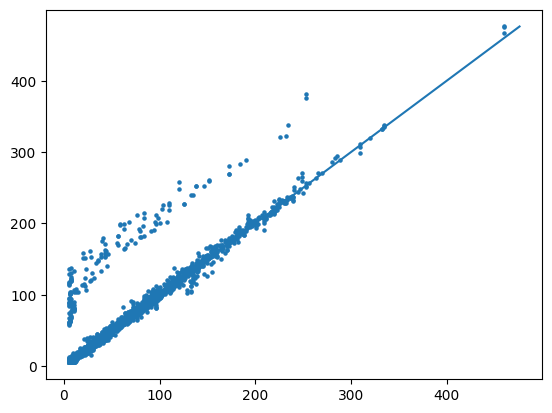

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(price, test, s=5)
x = np.linspace(min(test), max(test))
plt.plot(x,x)